In [105]:
from pyspark.sql import SparkSession

In [106]:
from pyspark.sql.functions import col,desc
import matplotlib.pyplot as plt
import seaborn as sns
import databricks.koalas as ks
from pyspark.sql import functions as F
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import folium
from folium.plugins import HeatMap
pio.renderers.default='notebook'
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import sweetviz as sv
from pyspark.sql.functions import when
from pyspark.sql.window import Window
from pyspark.sql.functions import col, to_date, month
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

In [107]:
spark =SparkSession.builder.appName("sample_hadoop")\
      .master("local[*]").config("spark.driver.memory","5g")\
      .config("spark.driver.host","127.0.0.1")\
      .config("spark.driver.bindAddress","127.0.0.1")\
      .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
      .getOrCreate()

In [108]:
csv_path_casualty = 'hdfs://localhost:9000/user/kiran_g/dft-road-casualty-statistics-casualty-1979-latest-published-year.csv'
csv_path_collision = "hdfs://localhost:9000/user/kiran_g/dft-road-casualty-statistics-collision-1979-latest-published-year.csv"
csv_path_vehicle = "hdfs://localhost:9000/user/kiran_g/dft-road-casualty-statistics-vehicle-1979-latest-published-year.csv"


df_casualty = spark.read.csv(csv_path_casualty, header=True, inferSchema=True)
df_collision = spark.read.csv(csv_path_collision, header=True, inferSchema=True)
df_vehicle = spark.read.csv(csv_path_vehicle, header=True, inferSchema=True)



In [109]:
df_casualty.printSchema()
df_casualty.show(5)

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- casualty_reference: integer (nullable = true)
 |-- casualty_class: integer (nullable = true)
 |-- sex_of_casualty: integer (nullable = true)
 |-- age_of_casualty: integer (nullable = true)
 |-- age_band_of_casualty: integer (nullable = true)
 |-- casualty_severity: integer (nullable = true)
 |-- pedestrian_location: integer (nullable = true)
 |-- pedestrian_movement: integer (nullable = true)
 |-- car_passenger: integer (nullable = true)
 |-- bus_or_coach_passenger: integer (nullable = true)
 |-- pedestrian_road_maintenance_worker: integer (nullable = true)
 |-- casualty_type: integer (nullable = true)
 |-- casualty_home_area_type: integer (nullable = true)
 |-- casualty_imd_decile: integer (nullable = true)
 |-- lsoa_of_casualty: string (nullable = true)

+--------------+-------------+-

In [110]:

df_collision.printSchema()
df_collision.show(5)

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- location_easting_osgr: string (nullable = true)
 |-- location_northing_osgr: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- police_force: integer (nullable = true)
 |-- accident_severity: integer (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- local_authority_district: integer (nullable = true)
 |-- local_authority_ons_district: string (nullable = true)
 |-- local_authority_highway: string (nullable = true)
 |-- first_road_class: integer (nullable = true)
 |-- first_road_number: integer (nullable = true)
 |-- road_type: integer (nullable = true)
 |-- speed_limit: string (nullable = 

In [111]:
df_vehicle.printSchema()
df_vehicle.show(5)

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- vehicle_type: integer (nullable = true)
 |-- towing_and_articulation: integer (nullable = true)
 |-- vehicle_manoeuvre: integer (nullable = true)
 |-- vehicle_direction_from: integer (nullable = true)
 |-- vehicle_direction_to: integer (nullable = true)
 |-- vehicle_location_restricted_lane: integer (nullable = true)
 |-- junction_location: integer (nullable = true)
 |-- skidding_and_overturning: integer (nullable = true)
 |-- hit_object_in_carriageway: integer (nullable = true)
 |-- vehicle_leaving_carriageway: integer (nullable = true)
 |-- hit_object_off_carriageway: integer (nullable = true)
 |-- first_point_of_impact: integer (nullable = true)
 |-- vehicle_left_hand_drive: integer (nullable = true)
 |-- journey_purpose_of_driver: integer (nullable = true)
 |-- sex_of_driver: integer

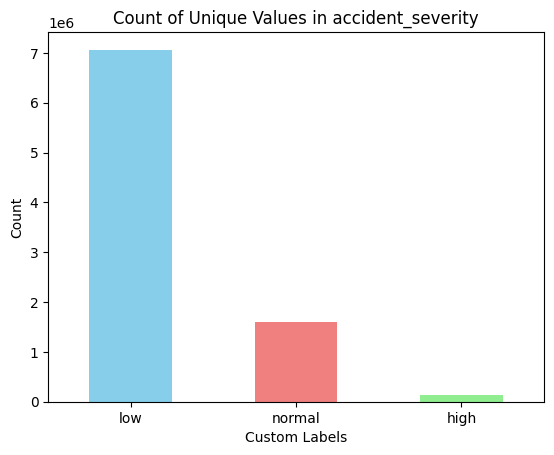

In [112]:
# Define custom labels and colors
value_counts = df_collision.groupBy("accident_severity").count().orderBy(col("count").desc(), "accident_severity")
custom_labels = ['low', 'normal', 'high']# Define custom labels and colors
colors = ['skyblue', 'lightcoral', 'lightgreen']
value_counts_pd = value_counts.toPandas()# Convert Spark DataFrame to Pandas DataFrame for plotting
ax = value_counts_pd.plot(kind='bar', x='accident_severity', y='count', color=colors)# Plot the bar chart
plt.xlabel('Custom Labels')
plt.ylabel('Count')
plt.title('Count of Unique Values in accident_severity')
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels, rotation=0)
ax.get_legend().remove()
plt.show()


<Figure size 1500x700 with 0 Axes>

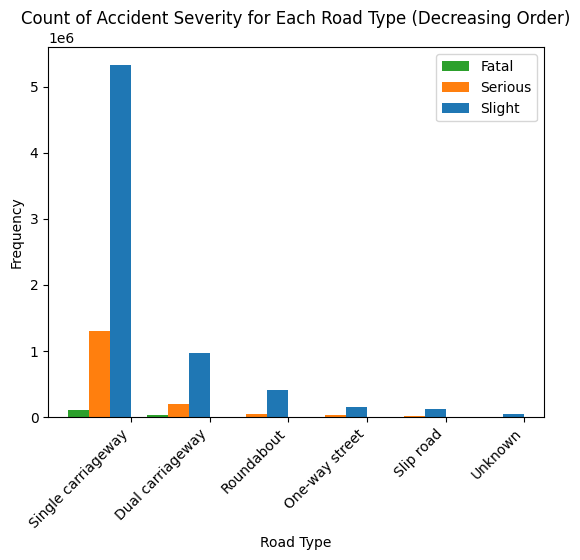

In [113]:
df_filtered = df_collision.filter((col("road_type") != -1) & (col("road_type") != 7))
df_filtered.createOrReplaceTempView("accident_data")
result_df = spark.sql("""
    SELECT road_type, accident_severity, COUNT(*) as frequency
    FROM accident_data
    GROUP BY road_type, accident_severity
    ORDER BY road_type, accident_severity
""")
pivot_df = result_df.groupBy("road_type").pivot("accident_severity").agg(F.first("frequency")).fillna(0)
pandas_df = pivot_df.toPandas()
pandas_df['total'] = pandas_df.sum(axis=1)
pandas_df = pandas_df.sort_values(by='total', ascending=False).drop('total', axis=1)
custom_colors = ['#2ca02c', '#ff7f0e', '#1f77b4']
plt.figure(figsize=(15, 7))
pandas_df.plot(kind='bar', x='road_type', stacked=False, color=custom_colors, rot=45, position=1, width=0.8)
plt.xlabel('Road Type')
plt.ylabel('Frequency')
plt.title('Count of Accident Severity for Each Road Type (Decreasing Order)')
plt.legend(['Fatal','Serious','Slight'])
ax = plt.gca()
ax.set_xticklabels(['Single carriageway', 'Dual carriageway', 'Roundabout',
                    'One-way street',
                    'Slip road', 'Unknown'], rotation=45, ha='right') 
plt.show()


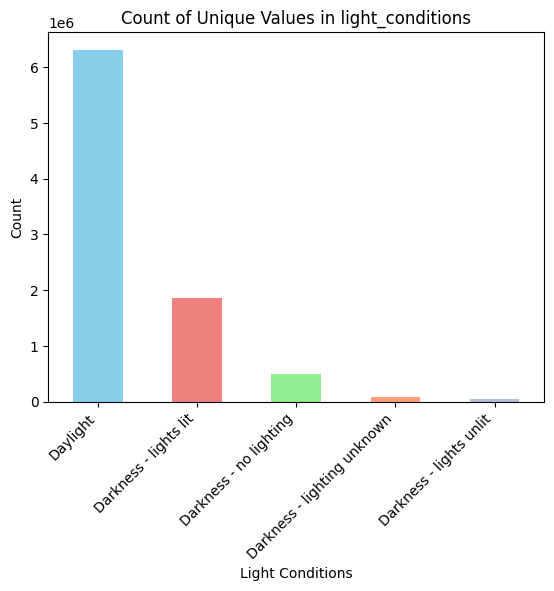

In [114]:
df_filtered = df_collision.filter(df_collision["light_conditions"] != -1)
value_counts = df_filtered.groupBy("light_conditions").count().orderBy("count", ascending=False)
pandas_value_counts = value_counts.toPandas()
custom_colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightsteelblue']
ax = pandas_value_counts.plot(kind='bar', x='light_conditions', y='count', color=custom_colors)
plt.xlabel('Light Conditions')
plt.ylabel('Count')
plt.title('Count of Unique Values in light_conditions')
ax.set_xticklabels(['Daylight',
                    'Darkness - lights lit',
                    'Darkness - no lighting',
                    'Darkness - lighting unknown',
                    'Darkness - lights unlit'], rotation=45, ha='right')

ax.get_legend().remove()
plt.show()

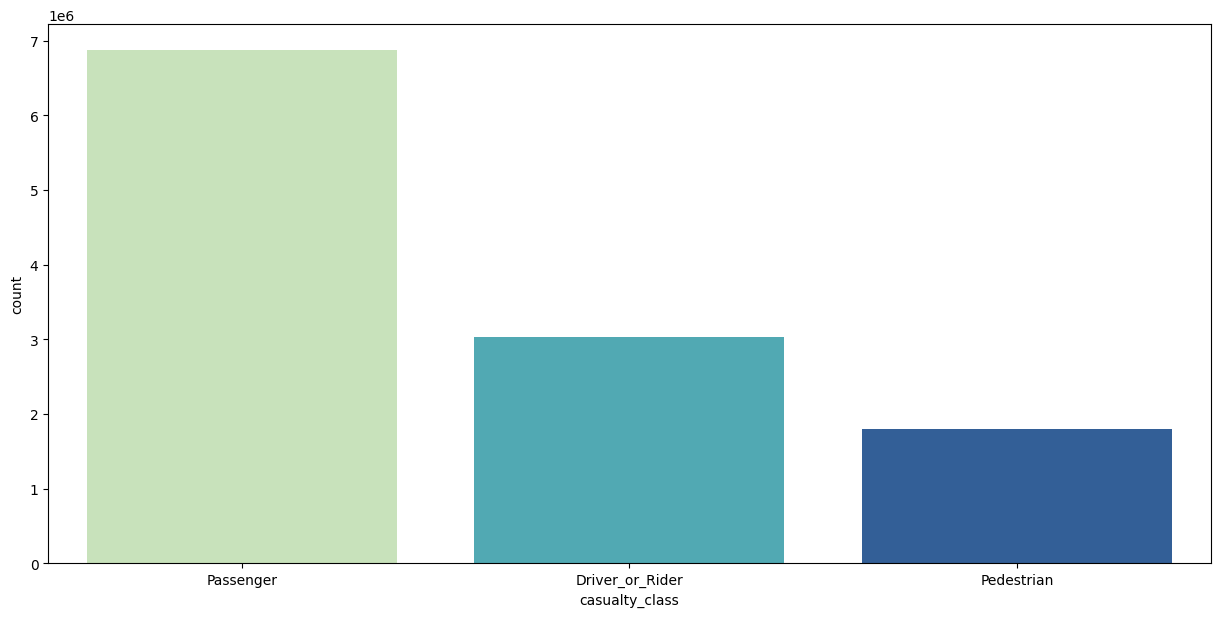

In [115]:
df_casualty.createOrReplaceTempView("casualty_table")
ordered_df = spark.sql("""
    SELECT casualty_class, COUNT(*) AS count
    FROM casualty_table
    GROUP BY casualty_class
    ORDER BY count DESC
""")# Run SQL query to get the ordered DataFrame
pandas_ordered_df = ordered_df.toPandas()# Convert the PySpark DataFrame to Pandas for plotting with seaborn
plt.figure(figsize=(15, 7))# Create a count plot using seaborn
ax = sns.barplot(x='casualty_class', y='count', data=pandas_ordered_df, palette="YlGnBu",
                 order=pandas_ordered_df["casualty_class"])
ax.set_xticklabels(['Passenger', 'Driver_or_Rider', 'Pedestrian'])
plt.show()

In [159]:
Df_Collision_ = Df_Collision.dropna()

map_center = [Df_Collision_['latitude'].mean(), Df_Collision_['longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=10)

locations = Df_Collision_[['latitude', 'longitude']].values.tolist()

HeatMap(locations).add_to(my_map)

my_map.save('heatmap.html')

In [150]:
Df_Collision_D = Df_Collision_.iloc[0:1000]
location = Df_Collision_D['latitude'].mean(), Df_Collision_D['longitude'].mean()
m = folium.Map(location=location,zoom_start=15)
for i in range(0,len(Df_Collision_D)):
    folium.Marker([Df_Collision_D['latitude'].iloc[i],Df_Collision_D['Longitude'].iloc[i]]).add_to(m)

In [118]:
unique_values_count = df_vehicle.select("sex_of_driver").distinct().count()
print(unique_values_count)

4


In [119]:
unique_values_counts = df_vehicle.groupBy("sex_of_driver").count()
unique_values_counts.show()

+-------------+--------+
|sex_of_driver|   count|
+-------------+--------+
|           -1|   23195|
|            1|11041729|
|            3|  824160|
|            2| 3836733|
+-------------+--------+



In [120]:
df_filtered_vehicle = df_vehicle.filter(df_vehicle["sex_of_driver"] != -1)
unique_values_counts = df_filtered_vehicle.groupBy("sex_of_driver").count()
unique_values_counts.show()

+-------------+--------+
|sex_of_driver|   count|
+-------------+--------+
|            1|11041729|
|            3|  824160|
|            2| 3836733|
+-------------+--------+



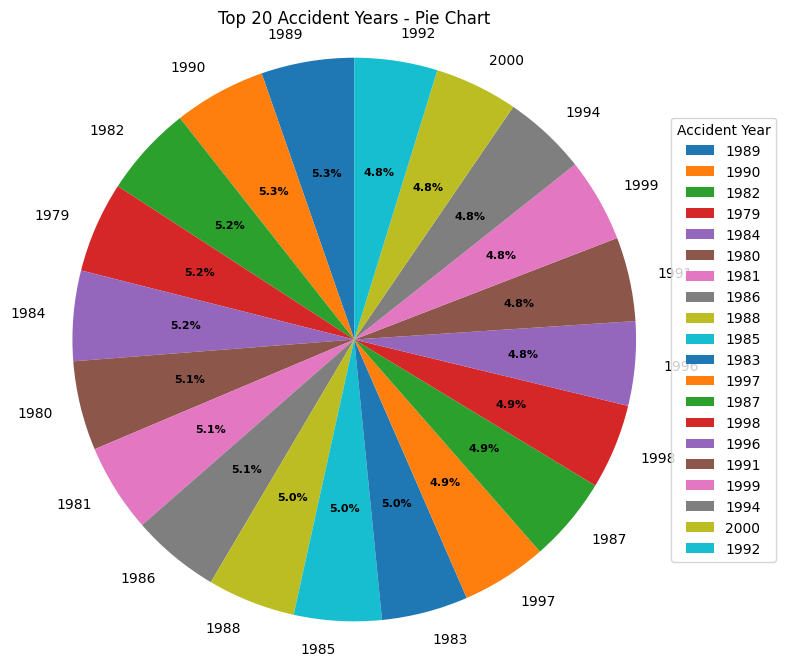

In [121]:
value_counts = df_collision.groupBy("accident_year").count().orderBy("count", ascending=False).limit(20)
pandas_value_counts = value_counts.toPandas()# Convert PySpark DataFrame to Pandas for plotting
fig, ax = plt.subplots(figsize=(8, 8))# Convert PySpark DataFrame to Pandas for plotting
wedges, texts, autotexts = ax.pie(pandas_value_counts["count"], labels=pandas_value_counts["accident_year"],
                                  autopct='%1.1f%%', startangle=90)
ax.legend(wedges, pandas_value_counts["accident_year"], title="Accident Year", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")# Add legend
ax.axis("equal")# Set the aspect ratio to be equal, ensuring a circular pie chart
plt.title('Top 20 Accident Years - Pie Chart')
plt.show()

In [175]:
value_counts = df_collision.groupBy("accident_year").count().orderBy("count", ascending=False).limit(20)
pandas_value_counts = value_counts.toPandas()
fig = px.pie(pandas_value_counts, names="accident_year", values="count",
             title='Top 20 Accident Years - Interactive Pie Chart',
             labels={'count': 'Accident Count', 'accident_year': 'Accident Year'},
             hole=0.3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer='browser')

In [176]:
day_mapping = {
    1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'
}
df_with_day_names = df_collision.withColumn("day_name", when(df_collision["day_of_week"] == 1, "Monday")
                                           .when(df_collision["day_of_week"] == 2, "Tuesday")
                                           .when(df_collision["day_of_week"] == 3, "Wednesday")
                                           .when(df_collision["day_of_week"] == 4, "Thursday")
                                           .when(df_collision["day_of_week"] == 5, "Friday")
                                           .when(df_collision["day_of_week"] == 6, "Saturday")
                                           .when(df_collision["day_of_week"] == 7, "Sunday")
                                           .otherwise("Unknown"))
value_counts = df_with_day_names.groupBy("day_name").count().orderBy("count")# Calculate value counts for each day of the week
pandas_value_counts = value_counts.toPandas()
fig = px.bar(pandas_value_counts, x="day_name", y="count",
             title='Accidents by Day of the Week',
             labels={'count': 'Accident Count', 'day_name': 'Day of the Week'},
             color="day_name", color_discrete_sequence=px.colors.qualitative.Set3)# Convert PySpark DataFrame to Pandas for plotting
fig.show(renderer='browser')

In [169]:
df_with_date = df_collision.withColumn("date", to_date(col("date"), "dd/MM/yyyy"))
df_with_month = df_with_date.withColumn("month", month("date"))# Extract the month from the date
value_counts = df_with_month.groupBy("month").count().orderBy("month")# Calculate value counts for each month
pandas_value_counts = value_counts.toPandas()# Convert PySpark DataFrame to Pandas for plotting
fig = px.bar(pandas_value_counts, x="month", y="count",
             title='Accidents Count by Month',
             labels={'count': 'Accident Count', 'month': 'Month'},
             color="month", color_discrete_sequence=px.colors.qualitative.Set3)# Plot an interactive bar chart using plotly
fig.show(renderer='browser')

In [171]:
df_filtered_vehicle = df_collision.filter(df_collision["weather_conditions"] != -1)
unique_values_counts = df_filtered_vehicle.groupBy("weather_conditions").count()
unique_values_counts.show()# Show the result

+------------------+-------+
|weather_conditions|  count|
+------------------+-------+
|                 1|6799093|
|                 6|  14214|
|                 3|  54158|
|                 5| 127795|
|                 9| 112614|
|                 4| 134904|
|                 8| 316249|
|                 7|  65342|
|                 2|1183420|
+------------------+-------+



In [177]:
weather_conditions_mapping = {
    1: "Rain",
    2: "Snow",
    3: "Fog",
    4: "Wind",
    5: "Ice",
    6: "Storm",
    7: "Low Sunlight",
    8: "Freezing Rain",
    9: "Hail"
}
df_with_labels = df_filtered_vehicle.withColumn("weather_conditions_label",
                                                when(df_filtered_vehicle["weather_conditions"] == 1, "Rain")
                                                .when(df_filtered_vehicle["weather_conditions"] == 2, "Snow")
                                                .when(df_filtered_vehicle["weather_conditions"] == 3, "Fog")
                                                .when(df_filtered_vehicle["weather_conditions"] == 4, "Wind")
                                                .when(df_filtered_vehicle["weather_conditions"] == 5, "Ice")
                                                .when(df_filtered_vehicle["weather_conditions"] == 6, "Storm")
                                                .when(df_filtered_vehicle["weather_conditions"] == 7, "Low Sunlight")
                                                .when(df_filtered_vehicle["weather_conditions"] == 8, "Freezing Rain")
                                                .when(df_filtered_vehicle["weather_conditions"] == 9, "Hail")
                                                .otherwise("Unknown"))# Map the numeric values to labels using when and otherwise
value_counts = df_with_labels.groupBy("weather_conditions_label").count()# Calculate value counts for each weather condition
pandas_value_counts = value_counts.toPandas()# Convert PySpark DataFrame to Pandas for plotting
fig = px.pie(pandas_value_counts, names="weather_conditions_label", values="count",
             title='Weather Conditions Distribution',
             labels={'count': 'Count', 'weather_conditions_label': 'Weather Condition'},
             color="weather_conditions_label", color_discrete_sequence=px.colors.qualitative.Set3)# Plot a pie chart using plotly
fig.show(renderer='browser')

In [ ]:
Df_Collision['accident_index'] = Df_Collision['accident_index'].astype(str)
Df_Collision['accident_reference'] = Df_Collision['accident_reference'].astype(str)
Df_Collision['time'] = Df_Collision['time'].astype(str)
Df_Collision['local_authority_ons_district'] = Df_Collision['local_authority_ons_district'].astype(str)
Df_Collision['local_authority_highway'] = Df_Collision['local_authority_highway'].astype(str)
Df_Collision['lsoa_of_accident_location'] = Df_Collision['lsoa_of_accident_location'].astype(str)
Df_Collision['date'] = Df_Collision['date'].astype(str)
report = sv.analyze(Df_Collision)
report.show_html('sweetviz_report.html')

In [ ]:
Df_Vehicle['accident_index'] = Df_Vehicle['accident_index'].astype(str)
Df_Vehicle['accident_reference'] = Df_Vehicle['accident_reference'].astype(str)
Df_Vehicle['generic_make_model'] = Df_Vehicle['generic_make_model'].astype(str)
Df_Vehicle['lsoa_of_driver'] = Df_Vehicle['lsoa_of_driver'].astype(str)
report3 = sv.analyze(Df_Vehicle)
report3.show_html('Vehicles.html')

In [ ]:
Df_Casualty['accident_index'] = Df_Casualty['accident_index'].astype(str)
Df_Casualty['accident_reference'] = Df_Casualty['accident_reference'].astype(str)
Df_Casualty['lsoa_of_casualty'] = Df_Casualty['lsoa_of_casualty'].astype(str)
report1 = sv.analyze(Df_Casualty)
report1.show_html('sweetviz_report_casualtites.html')

In [127]:
casualty_filtered_columns = ['accident_index', 'accident_year', 'accident_reference', 'vehicle_reference',
                              'casualty_class', 'sex_of_casualty', 'age_of_casualty', 'casualty_imd_decile',
                              'age_band_of_casualty', 'car_passenger', 'casualty_type', 'casualty_home_area_type']
casualty_dataframe_after_cleaning = df_casualty.select(*casualty_filtered_columns)# Select the desired columns
casualty_dataframe_after_cleaning.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in casualty_dataframe_after_cleaning.columns]).show()# Show the count of missing values in each column

+--------------+-------------+------------------+-----------------+--------------+---------------+---------------+-------------------+--------------------+-------------+-------------+-----------------------+
|accident_index|accident_year|accident_reference|vehicle_reference|casualty_class|sex_of_casualty|age_of_casualty|casualty_imd_decile|age_band_of_casualty|car_passenger|casualty_type|casualty_home_area_type|
+--------------+-------------+------------------+-----------------+--------------+---------------+---------------+-------------------+--------------------+-------------+-------------+-----------------------+
|             0|            0|                 0|                0|             0|              0|              0|                  0|                   0|            0|            0|                      0|
+--------------+-------------+------------------+-----------------+--------------+---------------+---------------+-------------------+--------------------+-------------

In [128]:
casualty_dataframe_after_cleaning.show(5)

+--------------+-------------+------------------+-----------------+--------------+---------------+---------------+-------------------+--------------------+-------------+-------------+-----------------------+
|accident_index|accident_year|accident_reference|vehicle_reference|casualty_class|sex_of_casualty|age_of_casualty|casualty_imd_decile|age_band_of_casualty|car_passenger|casualty_type|casualty_home_area_type|
+--------------+-------------+------------------+-----------------+--------------+---------------+---------------+-------------------+--------------------+-------------+-------------+-----------------------+
| 197901A11AD14|         1979|         01A11AD14|                2|             1|              1|             -1|                 -1|                  -1|            0|          104|                     -1|
| 197901A1BAW34|         1979|         01A1BAW34|                1|             3|              2|             27|                 -1|                   6|            0

In [129]:
column_names_for_filter = ['accident_index', 'accident_year', 'accident_reference',
                            'vehicle_reference', 'vehicle_type',
                            'vehicle_manoeuvre', 'vehicle_direction_from', 'vehicle_direction_to',
                            'first_point_of_impact', 'vehicle_left_hand_drive',
                            'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
                            'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code',
                            'age_of_vehicle', 'generic_make_model', 'driver_imd_decile',
                            'driver_home_area_type']
dataframe_after_cleaning_vehicle = df_vehicle.select(*column_names_for_filter)# Select the desired columns
num_rows = dataframe_after_cleaning_vehicle.count()# Count the number of rows
num_columns = len(dataframe_after_cleaning_vehicle.columns)# Get the number of columns
print("Number of rows:", num_rows)# Show the results
print("Number of columns:", num_columns)

Number of rows: 15725817
Number of columns: 20


In [130]:
num_rows = df_collision.count()
num_columns = len(df_collision.columns)
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 8809915
Number of columns: 36


In [131]:
df_collision = df_collision.withColumn("longitude", df_collision["longitude"].cast("float"))
df_collision = df_collision.withColumn("latitude", df_collision["latitude"].cast("float"))
df_collision_after_conversion = df_collision.dropna()
df_collision_after_conversion.show()

+--------------+-------------+------------------+---------------------+----------------------+---------+---------+------------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+----------------------------+-----------------------+----------------+-----------------+---------+-----------+---------------+----------------+-----------------+------------------+---------------------------------+---------------------------------------+----------------+------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+---------------+-------------------------+
|accident_index|accident_year|accident_reference|location_easting_osgr|location_northing_osgr|longitude| latitude|police_force|accident_severity|number_of_vehicles|number_of_casualties|      date|day_of_week| time|local_authority_district|local_authority_ons_district|local_authority_highway|f

In [132]:
num_rows = df_collision_after_conversion.count()
num_columns = len(df_collision_after_conversion.columns)
print("Number of rows after removing null values:", num_rows)
print("Number of columns:", num_columns)

Number of rows after removing null values: 3922484
Number of columns: 36


In [133]:
list_columns_after_feature_selection = ["accident_index","accident_year",'number_of_casualties',"accident_reference","longitude","latitude","police_force","date","day_of_week","speed_limit","junction_detail","second_road_class","light_conditions","urban_or_rural_area","accident_severity"]
df_collision_After_cleaning = df_collision_after_conversion[list_columns_after_feature_selection]
num_rows = df_collision_After_cleaning.count()
num_columns = len(df_collision_After_cleaning.columns)
print("Number of rows after removing null values:", num_rows)
print("Number of columns:", num_columns)

Number of rows after removing null values: 3922484
Number of columns: 15


In [134]:
merged_df = df_collision_After_cleaning \
    .join(casualty_dataframe_after_cleaning, ['accident_index', 'accident_year', 'accident_reference'], 'left') \
    .join(dataframe_after_cleaning_vehicle,
          ['accident_index', 'accident_year', 'accident_reference', 'vehicle_reference'], 'left')

# Show the resulting DataFrame
merged_df.show()

+--------------+-------------+------------------+-----------------+--------------------+---------+---------+------------+----------+-----------+-----------+---------------+-----------------+----------------+-------------------+-----------------+--------------+---------------+---------------+-------------------+--------------------+-------------+-------------+-----------------------+------------+-----------------+----------------------+--------------------+---------------------+-----------------------+-------------------------+-------------+-------------+------------------+------------------+---------------+--------------+------------------+-----------------+---------------------+
|accident_index|accident_year|accident_reference|vehicle_reference|number_of_casualties|longitude| latitude|police_force|      date|day_of_week|speed_limit|junction_detail|second_road_class|light_conditions|urban_or_rural_area|accident_severity|casualty_class|sex_of_casualty|age_of_casualty|casualty_imd_decile

In [135]:
num_rows = merged_df.count()
num_columns = len(merged_df.columns)
print("Number of rows after removing null values:", num_rows)
print("Number of columns:", num_columns)

Number of rows after removing null values: 5270471
Number of columns: 40


In [136]:
df_complete_after_removing_null_values = merged_df.dropna()
num_rows = df_complete_after_removing_null_values.count()# Count the number of rows
num_columns = len(df_complete_after_removing_null_values.columns)# Get the number of columns
print("Number of rows after removing null values:", num_rows)# Show the results
print("Number of columns:", num_columns)

Number of rows after removing null values: 5270471
Number of columns: 40


In [137]:

string_columns = [c for c, t in df_complete_after_removing_null_values.dtypes if t == 'string']# Identify columns with data type 'string' (equivalent to 'object' in Pandas)
complete_dataset_after_removing_object = df_complete_after_removing_null_values.drop(*string_columns)# Drop columns of data type 'string'
complete_dataset_after_removing_object.show()# Show the resulting DataFrame

+-------------+-----------------+--------------------+---------+---------+------------+-----------+---------------+-----------------+----------------+-------------------+-----------------+--------------+---------------+---------------+-------------------+--------------------+-------------+-------------+-----------------------+------------+-----------------+----------------------+--------------------+---------------------+-----------------------+-------------------------+-------------+-------------+------------------+------------------+---------------+--------------+-----------------+---------------------+
|accident_year|vehicle_reference|number_of_casualties|longitude| latitude|police_force|day_of_week|junction_detail|second_road_class|light_conditions|urban_or_rural_area|accident_severity|casualty_class|sex_of_casualty|age_of_casualty|casualty_imd_decile|age_band_of_casualty|car_passenger|casualty_type|casualty_home_area_type|vehicle_type|vehicle_manoeuvre|vehicle_direction_from|vehic

In [138]:
num_rows = complete_dataset_after_removing_object.count()
num_columns = len(complete_dataset_after_removing_object.columns)
print("Number of rows after removing null values:", num_rows)
print("Number of columns:", num_columns)

Number of rows after removing null values: 5270471
Number of columns: 35


In [139]:
complete_dataset_after_removing_object.printSchema()

root
 |-- accident_year: integer (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- police_force: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- junction_detail: integer (nullable = true)
 |-- second_road_class: integer (nullable = true)
 |-- light_conditions: integer (nullable = true)
 |-- urban_or_rural_area: integer (nullable = true)
 |-- accident_severity: integer (nullable = true)
 |-- casualty_class: integer (nullable = true)
 |-- sex_of_casualty: integer (nullable = true)
 |-- age_of_casualty: integer (nullable = true)
 |-- casualty_imd_decile: integer (nullable = true)
 |-- age_band_of_casualty: integer (nullable = true)
 |-- car_passenger: integer (nullable = true)
 |-- casualty_type: integer (nullable = true)
 |-- casualty_home_area_type: integer (nullable = true)
 |-- vehicle_type: integer (nulla

In [140]:

x = ["urban_or_rural_area", "light_conditions", "day_of_week", "casualty_type", "first_point_of_impact", "latitude", "longitude", "casualty_imd_decile", "driver_imd_decile", "number_of_casualties"]
y = "accident_severity"
if "features" in complete_dataset_after_removing_object.columns:
    complete_dataset_after_removing_object = complete_dataset_after_removing_object.drop("features")
assembler = VectorAssembler(inputCols=x, outputCol="features_temp")# Create a VectorAssembler to assemble features into a single vector column
assembled_df = assembler.transform(complete_dataset_after_removing_object)
assembled_df = assembled_df.drop("features_temp")
(train_data, test_data) = assembled_df.randomSplit([0.8, 0.2], seed=42)
assembled_df = assembled_df.drop("features_temp")
lr = LogisticRegression(featuresCol="features_temp", labelCol=y)
pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(train_data)



In [141]:
predictions = model.transform(test_data)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=y, metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8202823451253944


In [142]:

rf = RandomForestClassifier(featuresCol="features_temp", labelCol=y, numTrees=10, maxDepth=5)# Initialize Random Forest Classifier
pipeline = Pipeline(stages=[assembler, rf])# Create a pipeline with the VectorAssembler and Random Forest Classifier
model = pipeline.fit(train_data)# Train the model
predictions = model.transform(test_data)# Make predictions on the test set
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=y, metricName="accuracy")# Evaluate the model using MulticlassClassificationEvaluator
accuracy = evaluator.evaluate(predictions)
print("Random Forest Accuracy:", accuracy)


Random Forest Accuracy: 0.8202946828955797


In [143]:
dt = DecisionTreeClassifier(featuresCol="features_temp", labelCol=y, maxDepth=5)
pipeline = Pipeline(stages=[assembler, dt])# Create a pipeline with the VectorAssembler and Decision Tree Classifier
model = pipeline.fit(train_data)# Train the model
predictions = model.transform(test_data)# Make predictions on the test set
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=y, metricName="accuracy")# Evaluate the model using MulticlassClassificationEvaluator
accuracy = evaluator.evaluate(predictions)
print("Decision Tree Accuracy:", accuracy)

Decision Tree Accuracy: 0.8210415925214132


# Additional Info

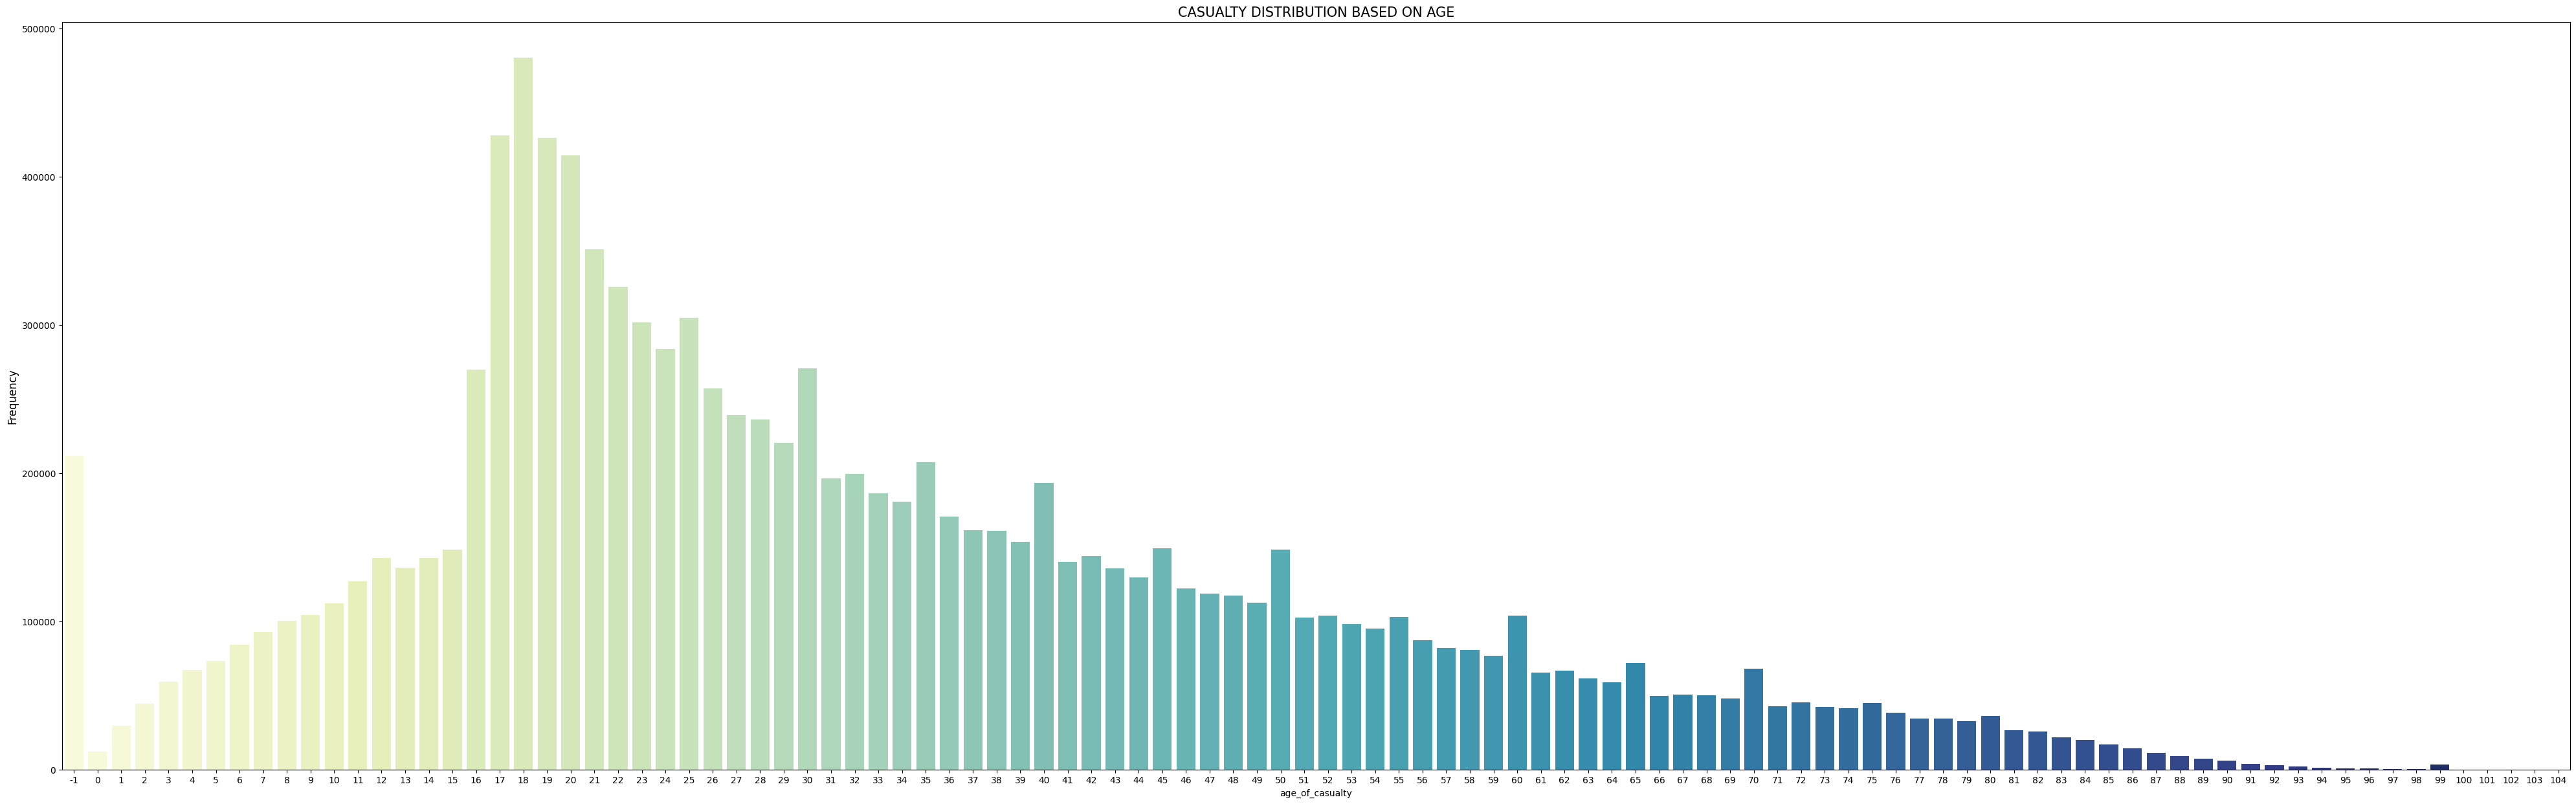

In [145]:
plt.figure(figsize=(50, 15))
sns.countplot(x='age_of_casualty', data=Df_Casualty, palette="YlGnBu")
plt.title('CASUALTY DISTRIBUTION BASED ON AGE', fontsize=15)
plt.ylabel("Frequency", fontsize=12)
plt.show()

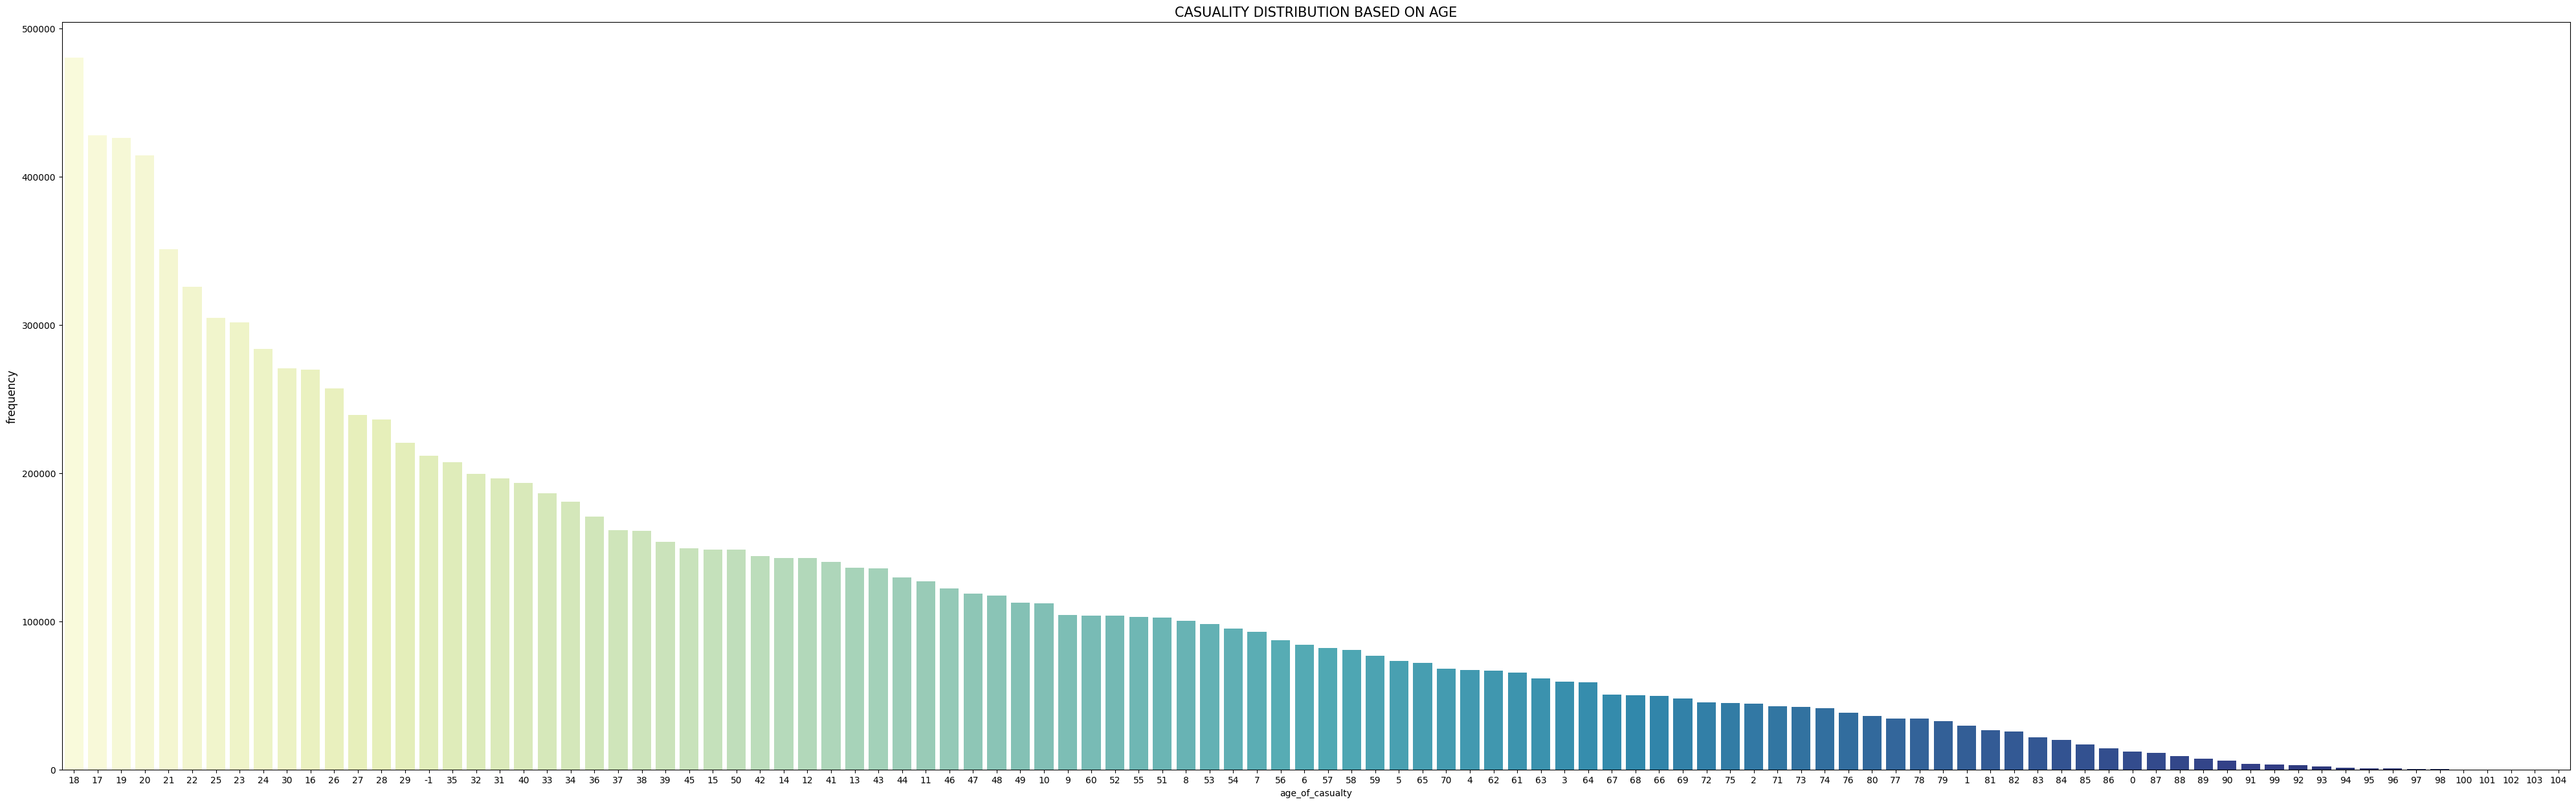

In [164]:
plt.figure(figsize=(50,15))
sns.countplot(x = 'age_of_casualty',data=Df_Casualty, 
              order = Df_Casualty["age_of_casualty"].value_counts().index, 
              palette = "YlGnBu")
plt.title('CASUALITY DISTRIBUTION BASED ON AGE', fontsize=15)
plt.ylabel("frequency", fontsize = 12)
plt.show()

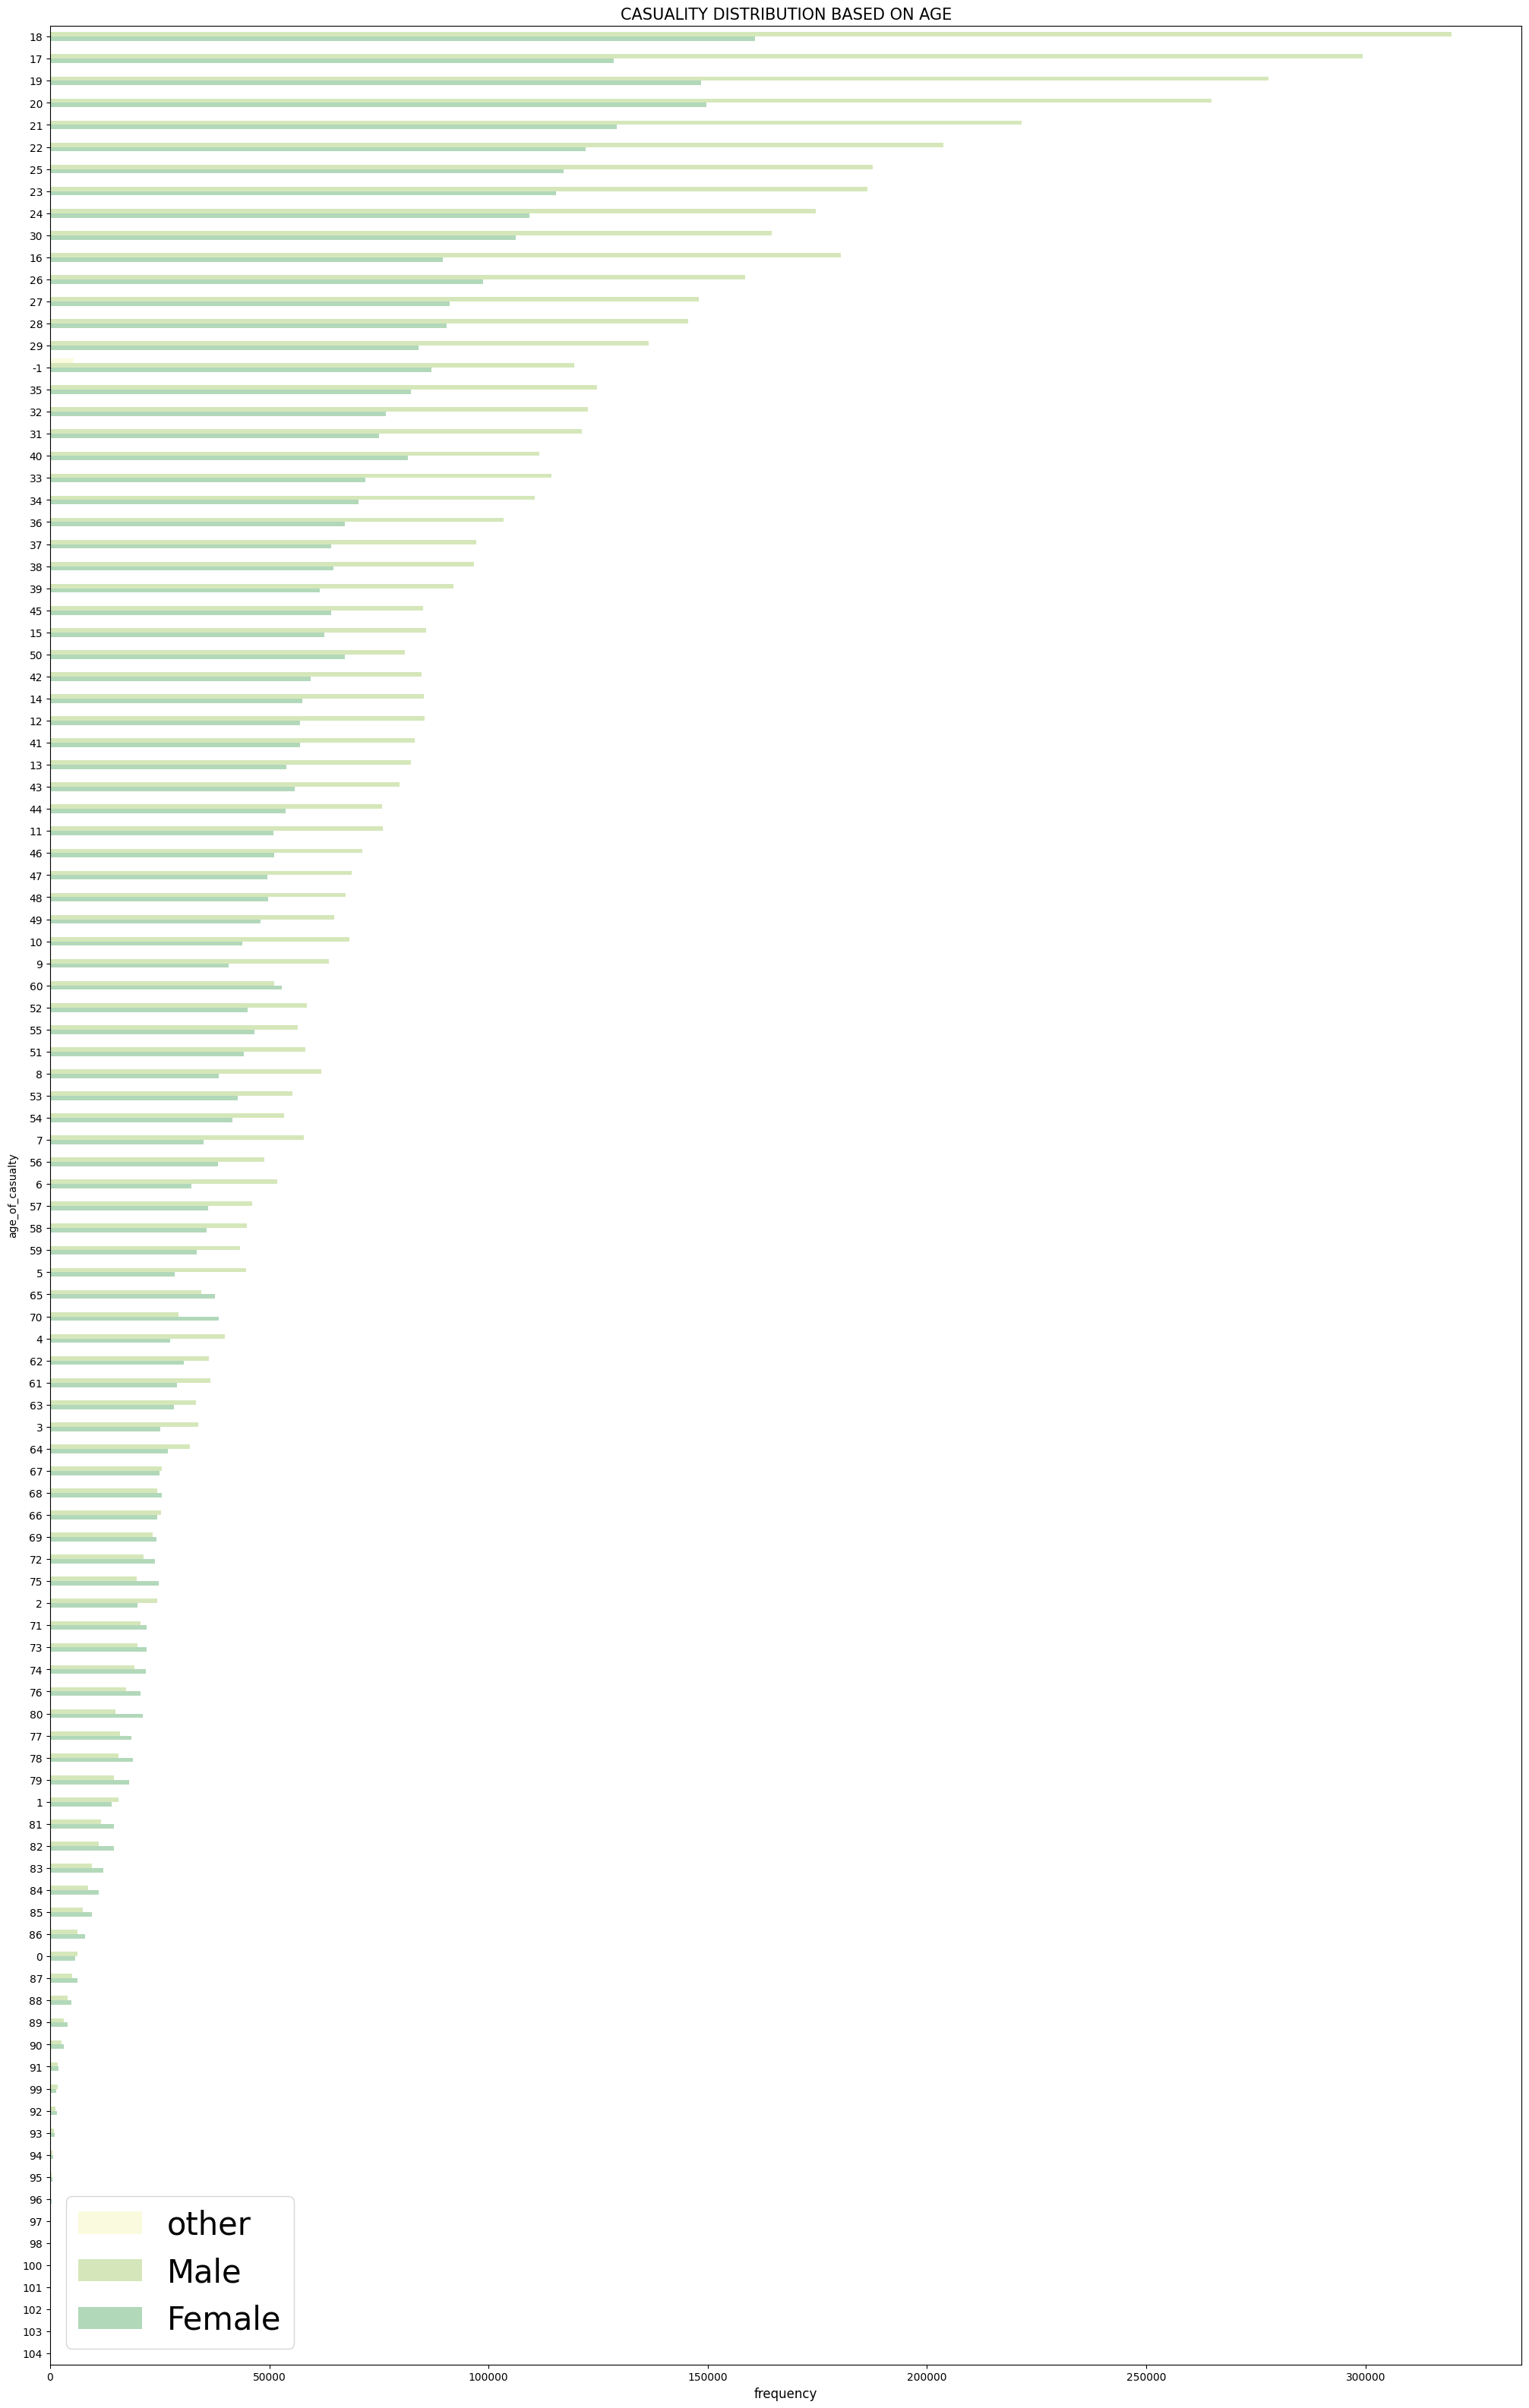

In [165]:
plt.figure(figsize=(25,40))
sns.countplot(y = 'age_of_casualty', hue = "sex_of_casualty",
              data=Df_Casualty, 
              order = Df_Casualty["age_of_casualty"].value_counts().index, 
              palette = "YlGnBu")
plt.title('CASUALITY DISTRIBUTION BASED ON AGE', fontsize=15)
plt.legend(['other','Male','Female'],prop={'size': 30}, loc=0)
plt.xlabel("frequency", fontsize = 12)
plt.show()

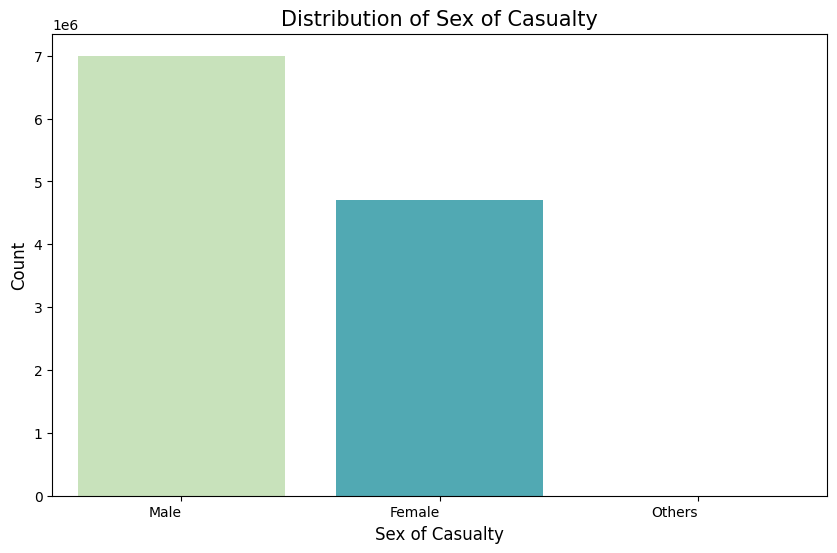

In [166]:
df_filtered_casuality = Df_Casualty[(Df_Casualty["sex_of_casualty"] != -1)]
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sex_of_casualty', data=df_filtered_casuality, palette='YlGnBu')
ax.set_xticklabels(['Male', 'Female','Others'], ha='right') 
plt.title('Distribution of Sex of Casualty', fontsize=15)
plt.xlabel('Sex of Casualty', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [157]:
Df_Collision_D = Df_Collision_.iloc[0:1000]
location = Df_Collision_D['latitude'].mean(), Df_Collision_D['longitude'].mean()
m = folium.Map(location=location,zoom_start=15)
for i in range(0,len(Df_Collision_D)):
    folium.Marker([Df_Collision_D['latitude'].iloc[i],Df_Collision_D['longitude'].iloc[i]]).add_to(m)
m

In [158]:
for i in range(0,len(Df_Collision_D)):
    num_of_casualties = Df_Collision_D['number_of_casualties'].iloc[i]
    if num_of_casualties == 1:
        color = 'blue'
    elif num_of_casualties == 2:
        color = 'green'
    else:
        color = 'red'
    
    popup = folium.Popup('Accident', parse_html=True) 
    folium.Marker([Df_Collision_D['latitude'].iloc[i],Df_Collision_D['longitude'].iloc[i]],popup=popup,icon=folium.Icon(color=color, icon='info-sign')).add_to(m)
m